In [1]:
import ipywidgets as widgets
from IPython.display import display

from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from shutil import copyfile

In [2]:
ffs_green = '#77b800'
ffs_blue = '#009fe3'
ffs_pink = '#e6007e'
ffs_yellow = '#fecc00'
ffs_cmap = colors.ListedColormap([ffs_green,ffs_blue,ffs_pink,ffs_yellow])

In [3]:
def split_comma_separated_index(series,delim=','):
    '''split comma separated items in series index, assign 1/n_names
    of value/count to each individual item.'''
    
    if series.dtype == 'object':
        # split grants with multiple institutions
        for row in series.iteritems():
            name = row[0]
            amount = row[1]

            names = name.split(delim)
            n_names = len(names)
            if n_names>1:
                series = series.drop(name)

                for idx in names:
                    idx = idx.strip()
                    if series.index.contains(idx):
                        series[idx] += amount/n_names
                    else:
                        series = series.append(pd.Series([amount/n_names],index=[idx]))
            
    return series

In [4]:
master = pd.read_excel('data/combined.xlsx')
master.set_index('MasterID',inplace=True)
master['Start year'] = master['Start date'].dt.year

In [5]:
class MasterFilter(widgets.HBox):
    
    def __init__(self, name = 'Filter 1'):
        super().__init__([])
        self.on = widgets.Checkbox(description=name,value=False)
        self.col = widgets.Dropdown(options=master.columns,description='Column',value='Disease Area')
        self.val  = widgets.Dropdown(options=sorted(master['Disease Area'].dropna().unique()),description='Value')
        self.children = [self.on, self.col, self.val]
        
        self.col.observe(self.col_changed)
        #self.on.observe(self.enable_changed)
        
    def col_changed(self,trait):
        if trait['name']=='label':
            self.val.options = sorted(master[trait['new']].dropna().unique())

class FilterList():
    def __init__(self,filters):
        self.filters = filters
    
    def get_filtered_master(self):
        filtered_master = master.copy()

        for f in self.filters:
            if f.on.value==True:
                col = f.col.value
                val = f.val.value
                filtered_master = filtered_master[filtered_master[col]==val]
                
        return filtered_master
        
filter1 = MasterFilter('Filter 1')
filter2 = MasterFilter('Filter 2')
filter3 = MasterFilter('Filter 3')

display(filter1,filter2,filter3)

filter_list = FilterList([filter1,filter2,filter3])

MasterFilter(children=(Checkbox(value=False, description='Filter 1'), Dropdown(description='Column', index=12,…

MasterFilter(children=(Checkbox(value=False, description='Filter 2'), Dropdown(description='Column', index=12,…

MasterFilter(children=(Checkbox(value=False, description='Filter 3'), Dropdown(description='Column', index=12,…

Grant Type
Project                14530713.06
PhD                     6903905.00
Basic Fellowship        2791600.00
Other                   2515534.38
Small Grant             1739826.94
Clinical Fellowship     1358675.00
Name: Fund Amount, dtype: float64

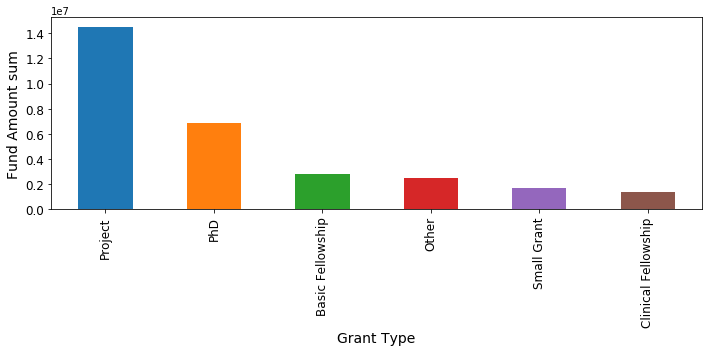

In [6]:
def plot(var_to_group, var_to_plot, stat, sort, ngroups, orientation, print_values,
         width, height):
    
    filtered_master = filter_list.get_filtered_master()
    plot_data = filtered_master.groupby(var_to_group)[var_to_plot].agg(stat)
    plot_data = split_comma_separated_index(plot_data)
    
    if sort:
        plot_data = plot_data.sort_values(ascending=False)
    
    if stat=='value_counts':
        plot_data = plot_data.unstack(fill_value=0)
    
    ax = plt.figure(figsize=(width, height)).gca()
    
    if orientation=='Horizontal':
        plot_data.head(ngroups).plot.barh(ax=ax,fontsize=12)
        plt.ylabel(var_to_group, fontsize=14)
        plt.xlabel(var_to_plot+' '+stat, fontsize=14)
    else:
        plot_data.head(ngroups).plot.bar(ax=ax,fontsize=12)
        plt.xlabel(var_to_group, fontsize=14)
        plt.ylabel(var_to_plot+' '+stat, fontsize=14)
    
    plt.tight_layout()
    plt.savefig('plots/tmp.png',dpi=300)
    
    plot_data.to_excel('plots/tmp.xlsx')
    
    if print_values:
        display(plot_data)
    
dropdown_group = widgets.Dropdown(options=master.columns,description='Grouped By',value='Grant Type')
dropdown_plot = widgets.Dropdown(options=master.columns,description='Plot',value='Fund Amount')
dropdown_stat = widgets.Dropdown(options=('count','sum','mean','min','max','value_counts'),description='Statistic',value='sum')
checkbox_sort = widgets.Checkbox(description='Sort Values',value=True)
checkbox_print = widgets.Checkbox(description='Print Values',value=True)

widget_ngroups = widgets.BoundedIntText(
                    value=30,
                    min=5,
                    max=100,
                    step=1,
                    description='No. Bars',
                )

widget_width = widgets.BoundedIntText(
                    value=10,
                    min=5,
                    max=20,
                    step=1,
                    description='Width',
                )
widget_height = widgets.BoundedIntText(
                    value=5,
                    min=5,
                    max=20,
                    step=1,
                    description='Height',
                )

widget_orientation = widgets.ToggleButtons(
    options=['Vertical', 'Horizontal'],
    description='Orientation:',
)


interactive_plot = widgets.interactive_output(
    plot,
    {'var_to_group': dropdown_group, 
     'var_to_plot': dropdown_plot, 
     'stat':dropdown_stat, 
     'sort':checkbox_sort,
     'ngroups':widget_ngroups,
     'orientation':widget_orientation,
     'print_values':checkbox_print,
     'width': widget_width,
     'height': widget_height}
)

display(widgets.VBox([dropdown_plot,
        dropdown_group,
        dropdown_stat,
        widget_ngroups,
        widget_orientation,
        widgets.HBox([widget_width,widget_height]),
        checkbox_sort,
        checkbox_print,
        interactive_plot]))

widget_fname = widgets.Text(
                    value='tmp',
                    placeholder='Type something',
                    description='File Name:',
                )

button_save = widgets.Button(description='Save Plot')
display(widgets.HBox([widget_fname, button_save]))

def on_button_clicked(b):
    copyfile('plots/tmp.png', 'plots/'+widget_fname.value+'.png')
    copyfile('plots/tmp.xlsx', 'plots/'+widget_fname.value+'.xlsx')

button_save.on_click(on_button_clicked)